# Data Visualization Project - Analyzing malicious and benign websites

#### Introduction
We are going to analyze the Malicious and Benign websites Dataset, which is a research production of a team of PHD students in University of ICESI. This project attempts to analyze and visualize characteristics of malicious and benign websites.

>I'm analysing purely for learning purposes, so there may be notes regarding different topics that helps me remember what I learnt.

#### Context
The project is created with the intention to evaluate how different classification models perform when predicting malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

#### Source
The original dataset is located at: https://www.kaggle.com/xwolf12/malicious-and-benign-websites

## Hypothesis

Fields `DNS_QUERY_TIMES`, `WHOIS_COUNTRY`, `NUMBER_SPECIAL_CHARACTERS`, `DIST_REMOTE_TCP_PORT` (Number of ports different from ports detected by TCP) and difference between `SOURCE_APP_PACKETS` & `REMOTE_APP_PACKETS` (difference between packets sent from honeypot to server and packets actually received by server) may be the best indicators to whether the website is malign or benign.


# EDA

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
from scipy import stats
import pandas_profiling
from matplotlib import cm
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (4, 4)

### Data Loading

First, we load in the dataset for analysis. The dataset is just titled "dataset.csv" and is located in the home directory. We will use Data Frames to represent the data.

In [2]:
df = pd.read_csv("dataset.csv")
df.head(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


Amount of entries in the dataset:

In [3]:
df.shape

(1781, 21)

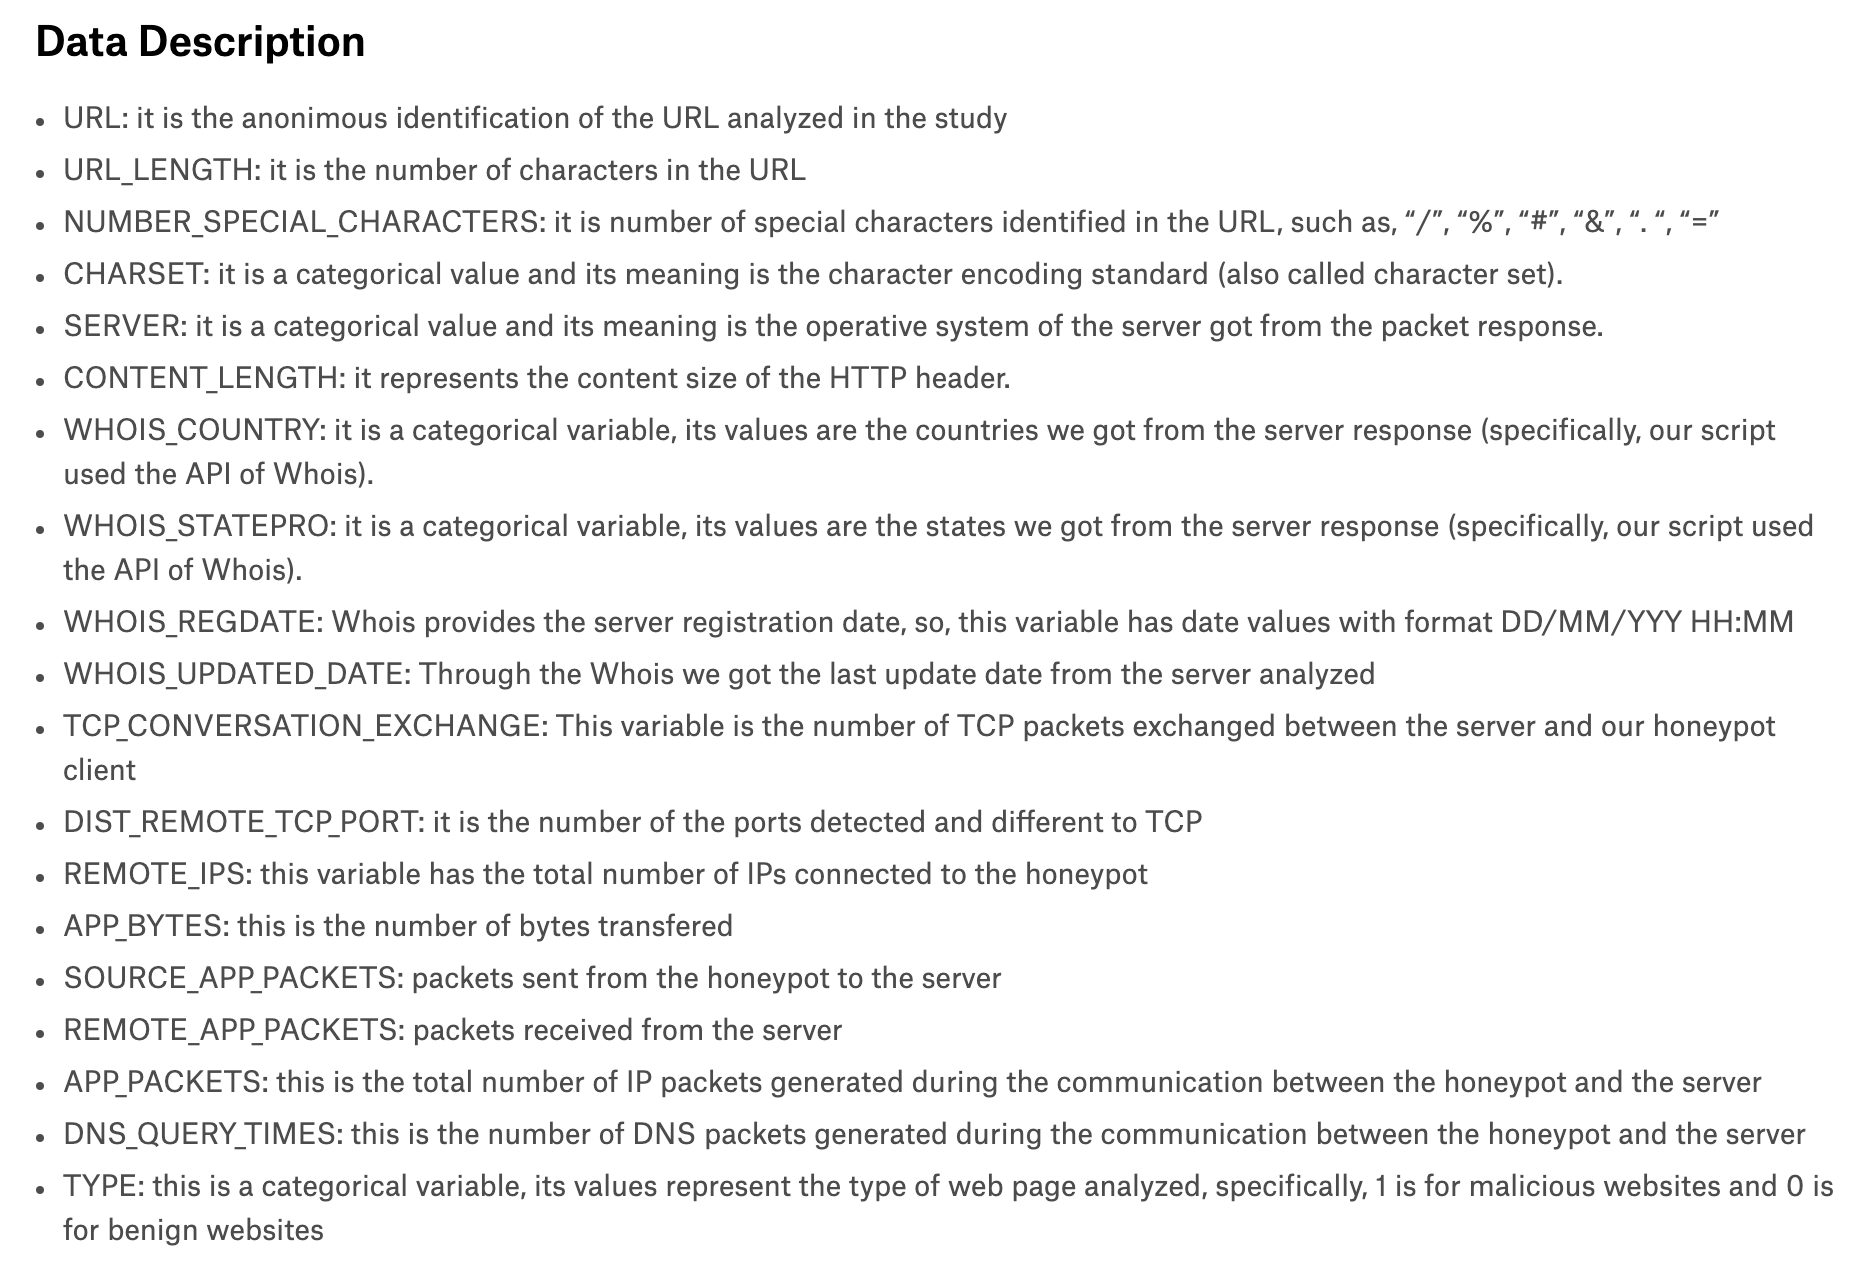

In [4]:
Image(filename='data_description.png')

## Quick look at the initial data

In [5]:
report = pandas_profiling.ProfileReport(df)
report

Number of variables,21
Number of observations,1781
Total Missing (%),2.2%
Total size in memory,292.3 KiB
Average record size in memory,168.0 B
Numeric,8
Categorical,6
Boolean,1
Date,0
Text (Unique),1
Rejected,5


From this report, we can see, among other things, that: 

1. `APP_BYTES` is positively skewed and has outliers with fairly high values.
2. `DIST_REMOTE_TCP_PORT` is also positively skewed
3. Most `SERVER`s are Apache or nginx
4. There are lots of NaN values -> needs to clean data



We see how many cases are for each class (malignant and benign)

In [6]:
df.Type.value_counts(normalize=True)

0    0.87872
1    0.12128
Name: Type, dtype: float64

Here, we can see that 87.87% of the websites are benign whilst only 12.12% of the websites are malignant.

## Data Cleaning

### Duplicates

After a quick check, we see that the dataset doesn't have any duplicates.

In [7]:
df[df.duplicated()]

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type


### Missing Values

Now, we will see if there are any fields with null values.

In [8]:
n_records = len(df)

def missing_values_df(df):
    for column in df:
        if (len(df[df[column].isnull()]) != 0):
            print("{} | {} | {}".format(
                column, len(df[df[column].isnull()]) / (1.0*n_records), df[column].dtype
            ))

missing_values_df(df)

SERVER | 0.0005614823133071309 | object
CONTENT_LENGTH | 0.45592363840539024 | float64
DNS_QUERY_TIMES | 0.0005614823133071309 | float64


We see that even though the fields `SERVER, CONTENT_LENGTH, DNS_QUERY_TIMES` have missing values, the amounts are very low. (highest one is `CONTENT_LENGTH` with 0.4% missing). Since it is such a small number of rows with missing data, we'll drop these rows.

In [9]:
df = df.dropna()
df.shape

(967, 21)

### Outliers

Here we'll look at the data to see if there are any outliers.

In [10]:
def outliers_col(df):
    for column in df:
        if df[column].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[column])) > 3])    
            print("{} | {} | {}".format(
                df[column].name,
                n_outliers,
                df[column].dtype
        ))

outliers_col(df)

URL_LENGTH | 15 | int64
NUMBER_SPECIAL_CHARACTERS | 9 | int64
CONTENT_LENGTH | 10 | float64
TCP_CONVERSATION_EXCHANGE | 9 | int64
DIST_REMOTE_TCP_PORT | 29 | int64
REMOTE_IPS | 12 | int64
APP_BYTES | 9 | int64
SOURCE_APP_PACKETS | 9 | int64
REMOTE_APP_PACKETS | 9 | int64
SOURCE_APP_BYTES | 9 | int64
REMOTE_APP_BYTES | 8 | int64
APP_PACKETS | 9 | int64
DNS_QUERY_TIMES | 2 | float64
Type | 0 | int64


Since there are minimal amounts of outliers in every numerical field, we will remove these fields if their z-score exceeds 3.

In [11]:
org_num_of_entries = df.shape[0]

df = df[ (np.abs(stats.zscore(df.URL_LENGTH)) < 3)  &
    (np.abs(stats.zscore(df.NUMBER_SPECIAL_CHARACTERS)) < 3) &
    (np.abs(stats.zscore(df.CONTENT_LENGTH)) < 3) &
    (np.abs(stats.zscore(df.TCP_CONVERSATION_EXCHANGE)) < 3) &
    (np.abs(stats.zscore(df.DIST_REMOTE_TCP_PORT)) < 3) &
    (np.abs(stats.zscore(df.REMOTE_IPS)) < 3) &
    (np.abs(stats.zscore(df.APP_BYTES)) < 3) &
    (np.abs(stats.zscore(df.SOURCE_APP_BYTES)) < 3) &
    (np.abs(stats.zscore(df.SOURCE_APP_PACKETS)) < 3) &
    (np.abs(stats.zscore(df.REMOTE_APP_BYTES)) < 3) &
    (np.abs(stats.zscore(df.REMOTE_APP_PACKETS)) < 3) &
    (np.abs(stats.zscore(df.APP_PACKETS)) < 3) &
    (np.abs(stats.zscore(df.DNS_QUERY_TIMES)) < 3)
]

print(("We removed {} entries").format(org_num_of_entries-(df.shape)[0]))

We removed 71 entries


### Description

In [12]:
df.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
mean,53.860491,10.534598,8475.652902,12.575893,2.381696,2.930804,1296.421875,14.728795,14.335938,9817.815848,1462.957589,14.728795,2.147321,0.117188
std,21.730486,3.478735,14651.817309,16.885114,3.920076,3.087859,1651.681946,18.613058,19.141691,25783.869245,1804.946555,18.613058,2.629560,0.321823
min,16.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1819.000000,7.000000,0.000000,2.000000,676.000000,8.000000,9.000000,633.000000,747.500000,8.000000,0.000000,0.000000
75%,64.000000,12.000000,10149.250000,19.000000,3.000000,5.000000,2094.750000,24.000000,22.250000,7316.250000,2441.500000,24.000000,4.000000,0.000000
max,129.000000,23.000000,118672.000000,127.000000,22.000000,13.000000,10999.000000,131.000000,148.000000,234205.000000,11147.000000,131.000000,10.000000,1.000000


In [13]:
df.corr()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.899592,0.235475,0.020804,0.059899,0.018389,0.017442,0.013600,0.010328,0.032123,0.012941,0.013600,-0.037495,-0.195293
NUMBER_SPECIAL_CHARACTERS,0.899592,1.000000,0.209290,0.028459,0.038932,0.037253,0.039435,0.031698,0.024801,0.014909,0.040794,0.031698,0.042437,-0.003127
CONTENT_LENGTH,0.235475,0.209290,1.000000,0.035426,-0.027019,-0.014379,-0.003755,0.022798,0.033032,0.080774,-0.010203,0.022798,-0.066734,-0.153315
TCP_CONVERSATION_EXCHANGE,0.020804,0.028459,0.035426,1.000000,0.359077,0.581359,0.942490,0.993722,0.979179,0.880382,0.932783,0.993722,0.611650,0.056448
DIST_REMOTE_TCP_PORT,0.059899,0.038932,-0.027019,0.359077,1.000000,0.568752,0.428943,0.371218,0.329344,0.127425,0.429152,0.371218,0.321451,-0.163916
REMOTE_IPS,0.018389,0.037253,-0.014379,0.581359,0.568752,1.000000,0.574098,0.605412,0.539726,0.235907,0.587841,0.605412,0.550304,0.079003
APP_BYTES,0.017442,0.039435,-0.003755,0.942490,0.428943,0.574098,1.000000,0.956221,0.926673,0.777352,0.996934,0.956221,0.715163,0.110281
SOURCE_APP_PACKETS,0.013600,0.031698,0.022798,0.993722,0.371218,0.605412,0.956221,1.000000,0.978453,0.847895,0.954777,1.000000,0.696263,0.097456
REMOTE_APP_PACKETS,0.010328,0.024801,0.033032,0.979179,0.329344,0.539726,0.926673,0.978453,1.000000,0.900498,0.920974,0.978453,0.637119,0.069236
SOURCE_APP_BYTES,0.032123,0.014909,0.080774,0.880382,0.127425,0.235907,0.777352,0.847895,0.900498,1.000000,0.751860,0.847895,0.347961,-0.050942


Now, if we look at the correlation at a quick glance:

We can tell that the `type` (malign or benign) is only loosely correlated to the `URL_LENGTH`, `NUMBER_SPECIAL_CHARACTERS` and `DNS_QUERY_TIMES`. So, let's look into these fields to see if we can find anything special. One thing we should note is that we are just looking at numerical data. We might also have to look at the 
`country` fields. 

## Variable Distribution

In [14]:
def numerical_variable_distribution(df, col):
    df[col].plot.kde(figsize=(4,4))
    plt.xlabel('Variable "{}" Distribution'.format(col))
    plt.show()

Now, we find all the columns with numbers so we can see how they are distributed:

In [15]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
interact(numerical_variable_distribution, col=numerical_columns, df=fixed(df))

interactive(children=(Dropdown(description='col', options=('URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT…

<function __main__.numerical_variable_distribution(df, col)>

Here we see that `type` (Malign v. Benign Websites) and `DNS_QUERY_TIMES` both have unbalanced distributions. 

> Since `DNS_QUERY_TIMES` logs the number of DNS packets generated during the communication between the honeypot (a network-attached-system appearing to be prone to attack and designed to lure in attackers) and the server, it may be closely related to whether the site is malign or not. 

Let's look into that:

In [16]:
df.DNS_QUERY_TIMES.value_counts(normalize=True)

0.0     0.536830
4.0     0.197545
6.0     0.131696
2.0     0.085938
8.0     0.042411
10.0    0.005580
Name: DNS_QUERY_TIMES, dtype: float64

Now, we compare the `DNS_QUERY_TIME` distribution to a normal distribution provided by scipy stats.

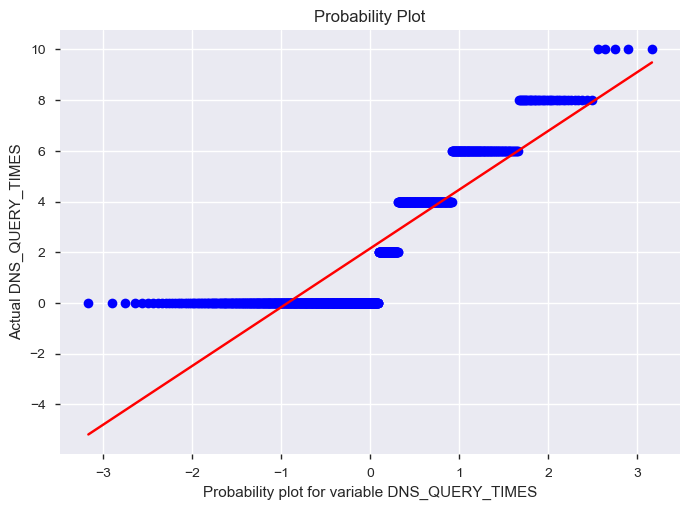

In [17]:
stats.probplot(df['DNS_QUERY_TIMES'], plot=plt)
plt.xlabel('Probability plot for variable {}'.format('DNS_QUERY_TIMES'))
plt.ylabel('Actual DNS_QUERY_TIMES')
plt.show()

Let's make sure by doing a **normality test** for each of these variables.

> A normality test is a hypothesis test where the null hypothesis $H_0$ is that the sample follows a normal distribution. Given a significance level (95%) we will reject the null hypothesis if the p-value is less than 0.05.

In [18]:
for num_col in numerical_columns:
    _, pval = stats.normaltest(df[num_col][df[num_col].notnull()])
    if(pval < 0.05):
        print("Column {} doesn't follow a normal distribution".format(num_col))
    else:
        print("Column {} follows a normal distribution".format(num_col))

Column URL_LENGTH doesn't follow a normal distribution
Column NUMBER_SPECIAL_CHARACTERS doesn't follow a normal distribution
Column CONTENT_LENGTH doesn't follow a normal distribution
Column TCP_CONVERSATION_EXCHANGE doesn't follow a normal distribution
Column DIST_REMOTE_TCP_PORT doesn't follow a normal distribution
Column REMOTE_IPS doesn't follow a normal distribution
Column APP_BYTES doesn't follow a normal distribution
Column SOURCE_APP_PACKETS doesn't follow a normal distribution
Column REMOTE_APP_PACKETS doesn't follow a normal distribution
Column SOURCE_APP_BYTES doesn't follow a normal distribution
Column REMOTE_APP_BYTES doesn't follow a normal distribution
Column APP_PACKETS doesn't follow a normal distribution
Column DNS_QUERY_TIMES doesn't follow a normal distribution
Column Type doesn't follow a normal distribution


Here, we see that none of these numerical values follow a normal distribution. (Not just `DNS_QUERY_TIMES`)

## Data Visualization

Here we'll try to visualize some data (not just numerical data) and see how they correlate with the `type` (whether a website is benign or malignant).

In order to better visualize these numerical data against the `types` (a categorical data), I'm going to group my variables and see how they are distributed first before plotting it against `types`.

In [19]:
url_length_types = ["short", "medium", "long"]
pd.qcut(df['URL_LENGTH'],3, url_length_types).value_counts()

short     314
long      297
medium    285
Name: URL_LENGTH, dtype: int64

In [20]:
special_character_types = ["few", "medium", "many"]
pd.qcut(df['NUMBER_SPECIAL_CHARACTERS'],3, special_character_types).value_counts()

few       406
many      259
medium    231
Name: NUMBER_SPECIAL_CHARACTERS, dtype: int64

In [21]:
content_length_types = ["short", "medium", "long"]
pd.qcut(df['CONTENT_LENGTH'],3, content_length_types).value_counts()

long      299
short     299
medium    298
Name: CONTENT_LENGTH, dtype: int64

The only category with an uneven distribution is `NUMBER_SPECIAL_CHARACTERS_TYPES` since it has relatively more `few` special characters. Let's proceed to visualize this column against types.

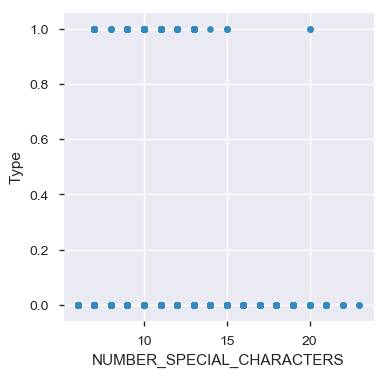

In [22]:
df.plot.scatter(x='NUMBER_SPECIAL_CHARACTERS', y='Type', figsize=(4,4))

>According to this graph, one thing to note is that malicious websites tend to have fewer special characters, contrary to my hypothesis.

In the above hypothesis, we also suspected that fields `DNS_QUERY_TIMES`, `WHOIS_COUNTRY`, `DIST_REMOTE_TCP_PORT`, `SOURCE_APP_PACKETS` & `REMOTE_APP_PACKETS` (difference between packets sent from honeypot to server and packets actually received by server) may be the best indicators to whether the website is malign or benign. 

Here we'll begin to visualise the relationship between these variables to see if we can find a correlation or indication that the site is malignant or not.

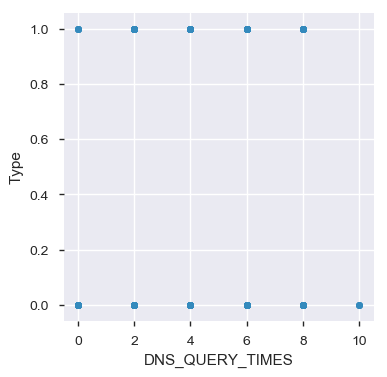

In [23]:
df.plot.scatter(x='DNS_QUERY_TIMES', y='Type', figsize=(4,4))

As we can see, there isn't much of an indication of whether a site is benign or malignant based solely on this metric. However, note that there is an outlier for the `DNS_QUERY_TIMES` of malign websites.

Moving on, in order to consider the field `WHOIS_COUNTRY`, we will also label them utilizing scikit-learn's preprocessing module.

Now, let's check out how the countries correlate with the type of website.

In [118]:
from sklearn.preprocessing import LabelEncoder
cle = LabelEncoder()
country_labels = cle.fit_transform(df.WHOIS_COUNTRY)
country_mappings = {index: label for index, label in 
                  enumerate(cle.classes_)}

df['COUNTRY_TYPES'] = country_labels
country_mappings

{0: 'AE',
 1: 'AT',
 2: 'AU',
 3: 'BE',
 4: 'BR',
 5: 'BS',
 6: 'BY',
 7: 'CA',
 8: 'CH',
 9: 'CN',
 10: 'CZ',
 11: 'Cyprus',
 12: 'DE',
 13: 'FR',
 14: 'GB',
 15: 'HK',
 16: 'IE',
 17: 'IL',
 18: 'IN',
 19: 'IT',
 20: 'JP',
 21: 'KR',
 22: 'KY',
 23: 'NL',
 24: 'NO',
 25: 'None',
 26: 'PA',
 27: 'PH',
 28: 'RU',
 29: 'SC',
 30: 'SE',
 31: 'SI',
 32: 'TR',
 33: 'UA',
 34: 'UG',
 35: 'UK',
 36: 'US',
 37: 'UY',
 38: 'United Kingdom',
 39: "[u'GB'; u'UK']",
 40: 'se',
 41: 'us'}

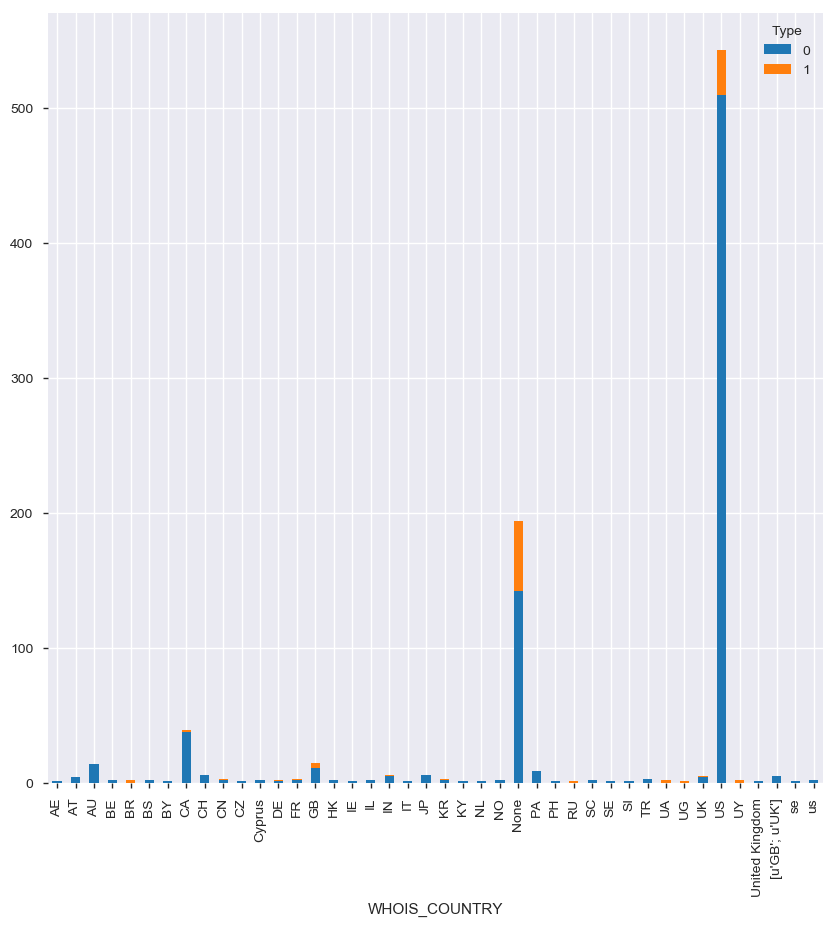

In [25]:
country_type_group = df.groupby(['WHOIS_COUNTRY', 'Type'])
country_type_group.size().unstack().fillna(0.0).plot(kind='bar', stacked=True, figsize=(10,10))

Since most website in the dataset is from the US, there might be bias when training the model. A note is that country BR has 2 malignant entries and no benign entries. Russia ,UG, UA, UY, BR also have malignant entries and no benign websites. On the other hand, BY, BS, AE, AT, AU, BE, CH, CZ and Cyprus all have entries for benign websites but none for malignant entries.

There are also a lot of malignant websites with country type `None`. Hence, it would be hard to say that one country has the most malignant websites. Due to the biased nature of the dataset, this would not be a good metric by itself (It may lean towards US and on identifying malignant sites from countries ).

Now, let's see how `DIST_REMOTE_TCP_PORT` fairs against the types.

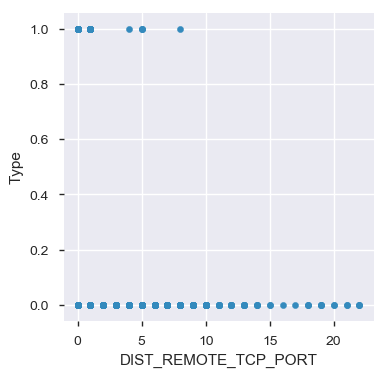

In [26]:
df.plot.scatter(x='DIST_REMOTE_TCP_PORT', y='Type', figsize=(4,4))

As we can see, the number of ports different from ports detected by TCP (`DIST_REMOTE_TCP_PORT`) is relatively spread out for benign websites. On the other hand, they are concentrated in the lower values for malignant website. This might be interesting.

# Evaluating the models

Since the types are binary (0 for benign, 1 for malignant), I will treat this as a binary classification problem.

Here, we first set up our evaluation functions.

In [38]:
def evaluate_model(true_classes, predictions):
    accuracy = metrics.accuracy_score(true_classes, predictions)
    precision = metrics.average_precision_score(true_classes, predictions)
    recall = metrics.recall_score(true_classes, predictions)
    auc = metrics.roc_auc_score(true_classes, predictions)
    f1 = metrics.f1_score(true_classes, predictions)
    print("""
    Accuracy: {:.3f}
    Precision: {:.3f}
    Recall: {:.3f}
    AUC: {:.3f}
    F1 Score: {:.3f}
    """.format(
        accuracy, 
        precision,
        recall,
        auc,
        f1
    ))

## Logistic Regression

> Logistic Regression is a classification learning algorithm designed to maximize the likelihood of a training set according to our model. With LR, the probabilities describing the possible outcomes of a single trial are modelled using a logistic function (parametric).

First, we have to setup the independent and target variables.

In [40]:
independent_variables = numerical_columns
target_variable = 'Type'

Then, we will start by training a simple Logistic Regression.

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import cross_val_score


X = df[independent_variables]
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [85]:
# fit the model
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [122]:
predictions = model.predict(X_test)
true_classes = y_test
prediction_probabilities = model.predict_proba(X_test)
prediction_probabilities[:5]

array([[9.99974864e-01, 2.51361082e-05],
       [9.53442469e-01, 4.65575309e-02],
       [9.74037041e-01, 2.59629592e-02],
       [9.93819402e-01, 6.18059828e-03],
       [7.25499873e-01, 2.74500127e-01]])

Let's plot the simple model to see how it fares:


The score of this model is: 0.9333333333333333



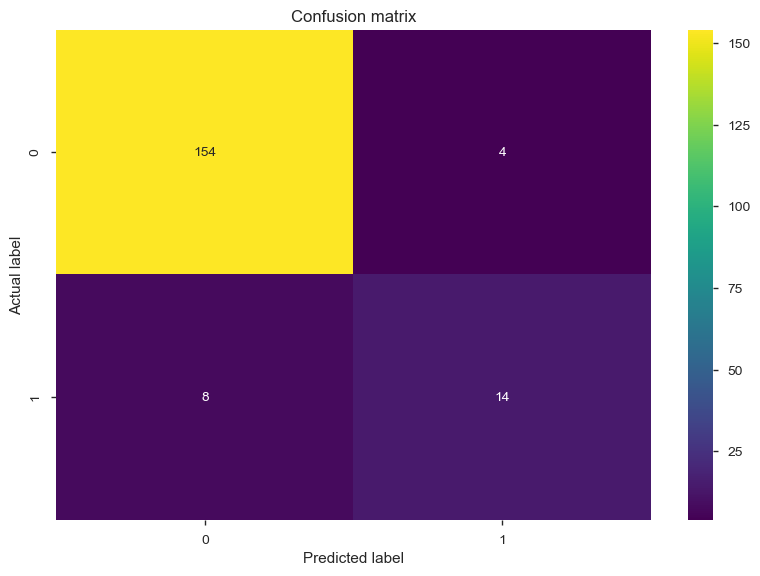

In [87]:
print(f'\nThe score of this model is: {model.score(X_test, y_test)}\n')

cnf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="viridis" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Evaluating it with a AUC/ROC curve. ROC curve is a plot of the true positive rate (Recall) against the false positive rate.

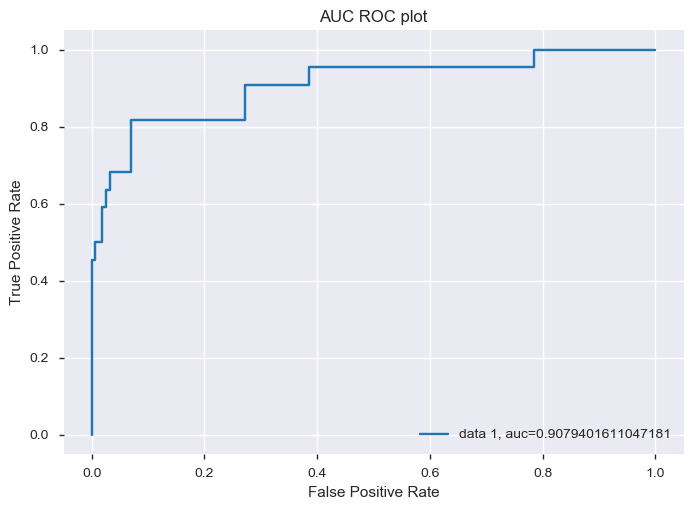

In [88]:
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_probabilities[::,1])
auc = metrics.roc_auc_score(y_test, prediction_probabilities[::,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC ROC plot")
plt.legend(loc=4)
plt.show()

In [89]:
evaluate_model(true_classes, predictions)


    Accuracy: 0.933
    Precision: 0.539
    Recall: 0.636
    AUC: 0.806
    F1 Score: 0.700
    


It seems like Logistic Regression fares alright. 

Despite the high `Accuracy` (% of correct identifications) and `AUC` score (*how the model balances the opposing efects of classifying correctly all positive cases without having many false positives.*), its `Precision` (*Habitility to correctly classify malignant websites as malignant, over the total number of sites it believes is malignant, including false positives*), `Recall` (*Habitility to correctly classify malignant websites over the true positives and false negative sites that are also malignant*) and `F1` (*Harmonic mean between recall and precision*) is mediocre.

> Suffice to say, the model has traded off and made it half-and-half for cases where benign sites are identified as malignant websites (precision-fp) and case where there are no false negatives -> classifying sites as benign sites when they are actually malignant (recall-fn).
Due to the scores, we can also infer that the dataset is largely imbalanced.

## Naive Bayes

> A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The primary issue for Naive Bayes is that the predictors have to be independent whilst in lots of use cases they aren't.

For this model, we will setup a Gaussian Naive Bayes Model since our values are continuous.

In [90]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [91]:
nb_pred = nb.predict(X_test)
evaluate_model(true_classes, nb_pred)


    Accuracy: 0.883
    Precision: 0.443
    Recall: 0.818
    AUC: 0.855
    F1 Score: 0.632
    


Here, we can see how Naive Bayes is not as good an estimator and doesn't match the Logistic Regression function in most part besides `Recall` (limiting the identification of benign sites that are actually malignant)

> Note that the higher Recall is particularly useful in this case as it is better to be more protective and limit false negatives

## K-Nearest Neighbor

> k-Nearest Neighbors (kNN) is a non-parametric learning algorithm. Contrary to other learning algorithms that allow discarding the training data after the model is built, kNN keeps all training examples in memory. Once a new, previously unseen example x comes in, the kNN algorithm finds k training examples closest to x and returns the majority label (in case of classification) or the average label 

For this non-parametric classification algorithm, we will use cross validation to determine the optimal hyperparameter `k`.

The optimal number of neighbors is 3


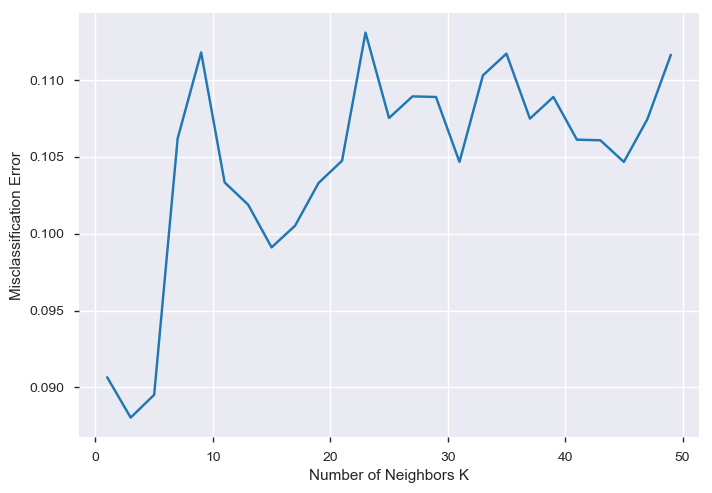

In [110]:
from sklearn.neighbors import KNeighborsClassifier

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
mean_squared_error = [1 - x for x in cv_scores]

# determining best k
idx = mean_squared_error.index(min(mean_squared_error))
optimal_k = neighbors[idx]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, mean_squared_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Knowing that the optimal k is 3, we will evaluate its score as follows:

In [111]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
k_pred = knn.predict(X_test)
evaluate_model(true_classes, k_pred)


    Accuracy: 0.922
    Precision: 0.504
    Recall: 0.682
    AUC: 0.819
    F1 Score: 0.682
    


In this case, the K-nearest neighbor algorithm fares similar to the Logistic Regression Function. Since the Logistic Regression metric has a higher Accuracy, we should probably go with LR when shooting for more accurate predictions. However, we should also keep in mind how Naive Bayes does better with false negatives.

## Decision Trees

> Given a data of attributes together with its classes, a decision tree produces a sequence of rules that can be used to classify the data. Note an issue of DTs is that they might create complex DTs that overfit the data.

For this model: Instead of coding the for-loop like above, we will try to use a GridSearch for the best hyperparameter.

In [113]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X_train, y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

1.0 {'max_depth': 3}


In [114]:
t_pred = tree_model.predict(X_test)
evaluate_model(true_classes, t_pred)


    Accuracy: 1.000
    Precision: 1.000
    Recall: 1.000
    AUC: 1.000
    F1 Score: 1.000
    


The 100% scores across all metrics are fishy and perhaps someone with more expertise could explain....

## Linear SVM

> This learning algorithm draws a decision boundary between classes. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

Below, I will simply pick my hyperparameters instead of running it through a GridSearch / RandomSearch due to the computationally expensive nature of the task.

In [115]:
from sklearn.svm import SVC
svm_model = SVC(kernel="linear", C=0.025, random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
evaluate_model(true_classes, svm_pred)


    Accuracy: 0.961
    Precision: 0.718
    Recall: 0.727
    AUC: 0.860
    F1 Score: 0.821
    


As seen, the Linear SVM might have the best `Accuracy` and, in general, the best trade off between `Precision` and `Recall` across all other models.

# Conclusion

In conclusion, ignoring the metrics for Decision Trees, a Linear Single Vector Machine might fare the best regarding metrics across the board whilst a Naive Bayes model might be a competitive choice due to its highest `recall` score.

## Citation

http://www.firewall.cx/networking-topics/protocols/domain-name-system-dns/160-protocols-dns-query.html

https://searchsecurity.techtarget.com/definition/honey-pot

https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/#how-does-knn-work

https://www.analyticsindiamag.com/7-types-classification-algorithms/